Implement edge-removal community detection algorithm on the Flicker Graph. 

Use the betweeness idea on edges and the Girvan–Newman Algorithm. 

The original dataset graph has more than 5M edges; in DM_resources there are 4 different sub-sampled graphs with edge counts from 2K to 600K; you can use these if the original is too big.


You should use a library to support graph operations (edges, vertices, paths, degrees, etc). 

We used igraph in python which also have builtin community detection algorithms (not allowed); these are useful as a way to evaluate communities you obtain

In [1]:
# %pip install igraph
# %pip install pycairo 
# %pip install cairocffi
# %pip install python-igraph


In [2]:
# imports:
import os
import igraph as ig
import numpy as np
import pandas as pd
import cairo
import matplotlib.pyplot as plt

In [2]:
%pip install networkx

  Using cached networkx-3.4.2-py3-none-any.whl.metadata (6.3 kB)
Using cached networkx-3.4.2-py3-none-any.whl (1.7 MB)
Note: you may need to restart the kernel to use updated packages.


Starting Girvan-Newman algorithm with max_communities=10...
Graph has 318 nodes and 2098 edges
Current communities: 5, Target: 10
Current communities: 6, Target: 10
Current communities: 8, Target: 10
Number of communities found: 10
Modularity at each step: [0.03837419268066824, 0.03835510872854533, 0.41075117161834646, 0.4129707034072124]
Best modularity: 0.4129707034072124 at step 3


C:\Users\koola\AppData\Local\Temp\ipykernel_96672\53071246.py:221: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('tab10', num_communities)


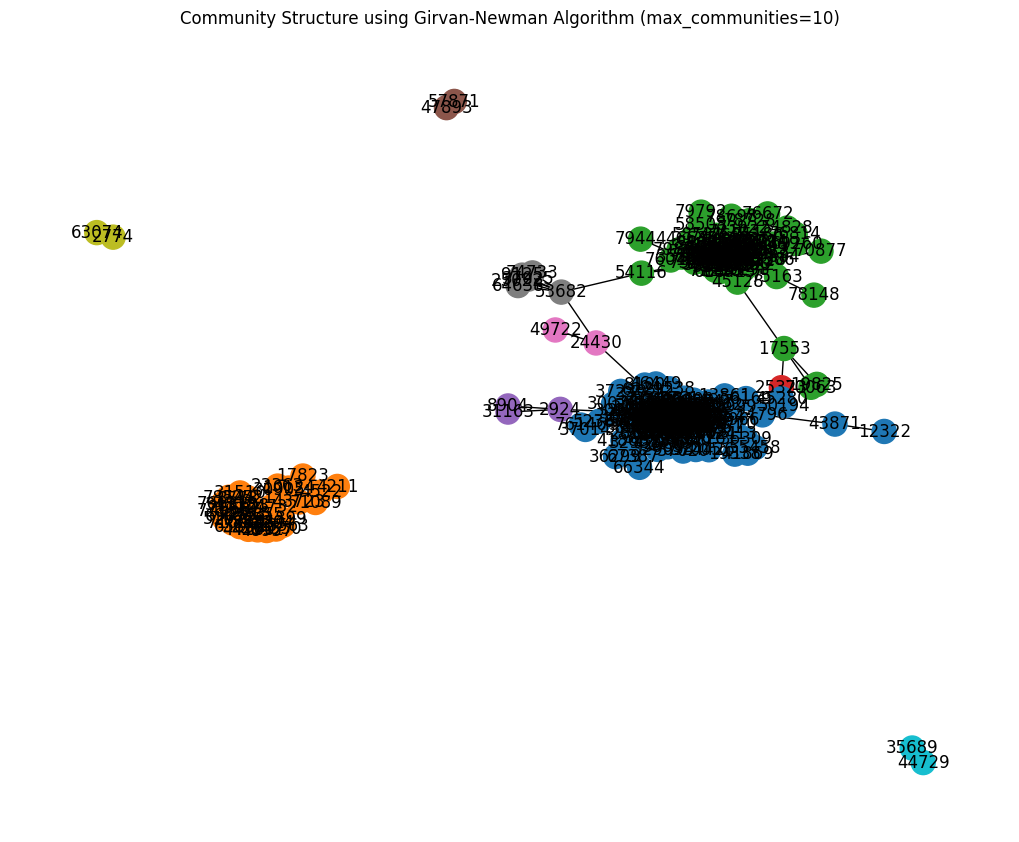

In [5]:
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import pandas as pd
import numpy as np
from collections import defaultdict, deque

# Load data
path = 'flickr/data/Flickr_sampled_edges/edges_sampled_2K.csv'
df = pd.read_csv(path, header=None, names=["source", "target"])

# Convert to integers to avoid numpy datatype issues
df['source'] = df['source'].astype(int)
df['target'] = df['target'].astype(int)

# Create graph
G = nx.Graph()
for index, row in df.iterrows():
    G.add_edge(int(row['source']), int(row['target']))

# Custom implementation of Girvan-Newman algorithm
def edge_betweenness_centrality(G):
    """
    Calculate the edge betweenness centrality for all edges in the graph.
    
    Returns:
        Dictionary of edge to betweenness value
    """
    # Initialize betweenness dictionary with edges as integers
    betweenness = {}
    for u, v in G.edges():
        # Convert numpy values to integers if needed
        u_int = int(u) if hasattr(u, 'item') else u
        v_int = int(v) if hasattr(v, 'item') else v
        edge = tuple(sorted([u_int, v_int]))
        betweenness[edge] = 0.0
    
    # For each node as a source
    for s in G.nodes():
        # Convert numpy value to integer if needed
        s_int = int(s) if hasattr(s, 'item') else s
        
        # Get the shortest paths and number of shortest paths
        # BFS to find shortest paths
        paths = defaultdict(list)  # node -> list of paths from s
        path_counts = {}  # node -> number of shortest paths from s
        distances = {}  # node -> distance from s
        
        for node in G.nodes():
            # Convert numpy values to integers if needed
            node_int = int(node) if hasattr(node, 'item') else node
            path_counts[node_int] = 0
            distances[node_int] = -1
        
        # BFS queue
        queue = deque([s_int])
        distances[s_int] = 0
        path_counts[s_int] = 1
        paths[s_int] = [[s_int]]
        
        while queue:
            node = queue.popleft()
            
            for neighbor in G.neighbors(node if isinstance(node, (int, str)) else s):
                # Convert numpy value to integer if needed
                neighbor_int = int(neighbor) if hasattr(neighbor, 'item') else neighbor
                
                # Found a new node
                if distances[neighbor_int] == -1:
                    distances[neighbor_int] = distances[node] + 1
                    queue.append(neighbor_int)
                
                # Found a shortest path
                if distances[neighbor_int] == distances[node] + 1:
                    path_counts[neighbor_int] += path_counts[node]
                    for path in paths[node]:
                        paths[neighbor_int].append(path + [neighbor_int])
        
        # Calculate betweenness
        # Start with nodes furthest from s and work backward
        nodes_by_distance = sorted([(node, dist) for node, dist in distances.items() if dist > 0],
                                  key=lambda x: -x[1])
        
        # Node dependencies: how many paths from s to other nodes go through node
        node_dependencies = {node: 0.0 for node in distances.keys()}
        
        for node, dist in nodes_by_distance:
            # Get parents (nodes that come before this one in shortest paths)
            parents = []
            for p in G.neighbors(node if isinstance(node, (int, str)) else 
                                int(node) if hasattr(node, 'item') else node):
                p_int = int(p) if hasattr(p, 'item') else p
                if distances.get(p_int, -1) == distances[node] - 1:
                    parents.append(p_int)
            
            for parent in parents:
                # Weight by the proportion of shortest paths through this parent
                if path_counts[node] > 0:  # Avoid division by zero
                    dependency = (path_counts[parent] / path_counts[node]) * (1 + node_dependencies[node])
                    node_dependencies[parent] += dependency
                    
                    # Update edge betweenness
                    edge = tuple(sorted([parent, node]))
                    if edge in betweenness:
                        betweenness[edge] += dependency
                    else:
                        # Try converting both elements to integers
                        edge_int = tuple(sorted([int(parent) if hasattr(parent, 'item') else parent, 
                                               int(node) if hasattr(node, 'item') else node]))
                        if edge_int in betweenness:
                            betweenness[edge_int] += dependency
    
    # Normalize by dividing by 2 (undirected graph)
    for edge in betweenness:
        betweenness[edge] /= 2.0
        
    return betweenness

def girvan_newman(G, max_communities=10):
    # Make a copy of the graph to work with
    g_copy = G.copy()
    
    # Store communities at each step
    all_communities = []
    modularity_values = []
    
    # Get initial connected components (communities)
    communities = [list(c) for c in nx.connected_components(g_copy)]
    all_communities.append(communities)
    modularity = nx.community.modularity(G, communities)
    modularity_values.append(modularity)
    
    # For larger networks, we can use a more efficient approach
    # by removing multiple edges with high betweenness at each iteration
    
    # Define how many edges to remove per iteration based on graph size
    num_edges = g_copy.number_of_edges()
    edges_per_iter = max(1, int(num_edges / 1000))  # Remove more edges in larger graphs
    
    while len(communities) < max_communities and g_copy.edges():
        print(f"Current communities: {len(communities)}, Target: {max_communities}")
        
        # Calculate edge betweenness
        edge_betweenness = edge_betweenness_centrality(g_copy)
        
        if not edge_betweenness:
            break  # No more edges
            
        # Sort edges by betweenness (highest first)
        sorted_edges = sorted(edge_betweenness.items(), key=lambda x: -x[1])
        
        # Remove multiple edges with highest betweenness
        edges_removed = 0
        for edge, _ in sorted_edges:
            if edges_removed >= edges_per_iter:
                break
                
            if g_copy.has_edge(*edge):  # Check if edge still exists
                g_copy.remove_edge(*edge)
                edges_removed += 1
        
        # Get new connected components
        new_communities = [list(c) for c in nx.connected_components(g_copy)]
        
        # If the number of communities has increased, store this state
        if len(new_communities) > len(communities):
            communities = new_communities
            all_communities.append(communities)
            modularity = nx.community.modularity(G, communities)
            modularity_values.append(modularity)
            
        # Break if we've reached the maximum number of communities
        if len(communities) >= max_communities:
            break
    
    return all_communities, modularity_values

# Run the algorithm with max_communities=10
print("Starting Girvan-Newman algorithm with max_communities=10...")
print(f"Graph has {G.number_of_nodes()} nodes and {G.number_of_edges()} edges")

# For larger graphs, limit the calculation to a subgraph for better performance
if G.number_of_nodes() > 5000:  # Arbitrary threshold, adjust based on your hardware
    print("Large graph detected, using a subgraph for better performance")
    # Take the largest connected component
    largest_cc = max(nx.connected_components(G), key=len)
    subgraph = G.subgraph(largest_cc).copy()
    
    # If still too large, sample nodes
    if len(largest_cc) > 3000:
        import random
        sample_size = 3000
        sampled_nodes = random.sample(list(largest_cc), sample_size)
        subgraph = G.subgraph(sampled_nodes).copy()
        print(f"Sampled {sample_size} nodes for analysis")
    
    G_analysis = subgraph
else:
    G_analysis = G

# Run the algorithm
all_communities, modularity_list = girvan_newman(G_analysis, max_communities=10)

# Handle empty results
if not modularity_list:
    print("No communities found! Using connected components as fallback.")
    communities = [list(c) for c in nx.connected_components(G)]
else:
    # Get the communities with the highest modularity
    best_community_idx = np.argmax(modularity_list)
    communities = all_communities[best_community_idx]

# Print information
print(f"Number of communities found: {len(communities)}")
print(f"Modularity at each step: {modularity_list}")
if modularity_list:
    print(f"Best modularity: {modularity_list[best_community_idx]} at step {best_community_idx}")

# Visualize the community structure
num_communities = len(communities)
cmap = cm.get_cmap('tab10', num_communities)
colors = [cmap(i) for i in range(num_communities)]
node_colors = []

for node in G.nodes():
    for i, community in enumerate(communities):
        if node in community:
            node_colors.append(colors[i])
            break

plt.figure(figsize=(10, 8))
nx.draw(G, with_labels=True, node_color=node_colors)
plt.title(f"Community Structure using Girvan-Newman Algorithm (max_communities={len(communities)})")
plt.show()

Number of communities found: 12


C:\Users\koola\AppData\Local\Temp\ipykernel_77984\762878081.py:30: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('tab10', num_communities)  # Use a colormap with enough colors


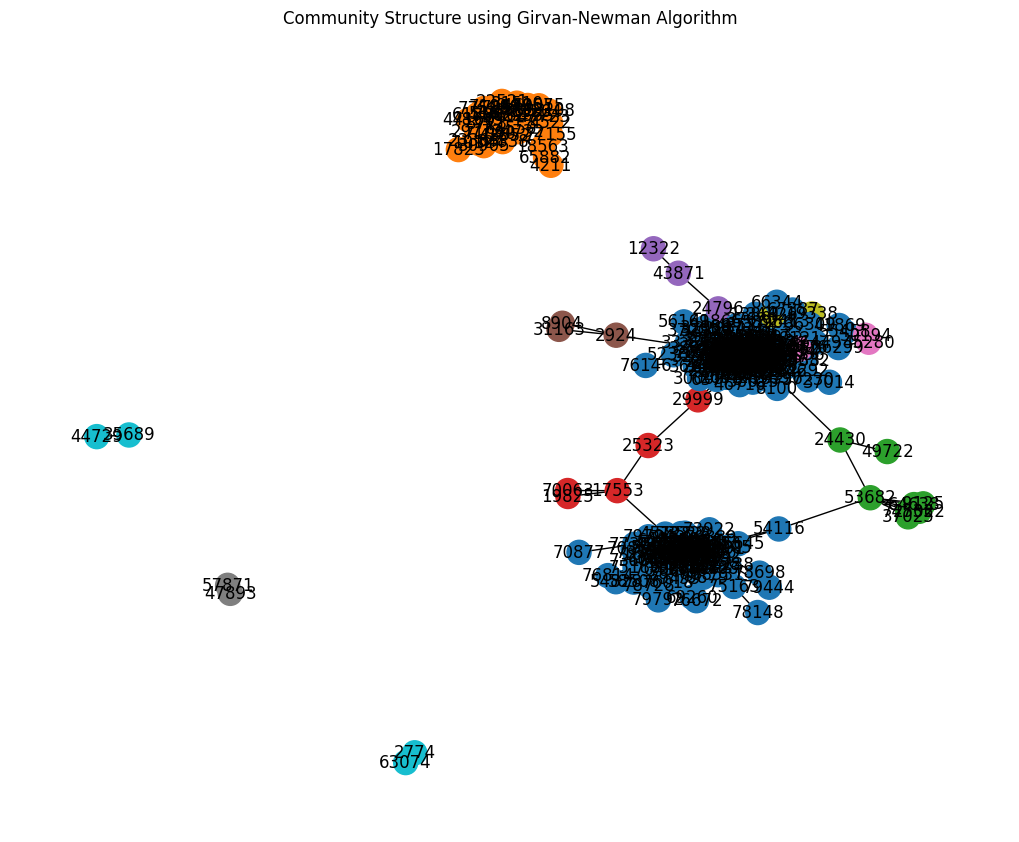

Modularity at each step: [0.41096745640907273, 0.41243555758309935, 0.4136759008761351, 0.41416435917451905, 0.41471688502645854, 0.4145831837666451, 0.41444936891187856, 0.4143154404621588, 0.4141813984174859, 0.41404724277786004, 0.41391297354328105, 0.41377859071374895, 0.41364409428926374, 0.4135094842698252, 0.41337476065543377, 0.41323992344608923, 0.41276736844114104, 0.4130436313671108, 0.41277236661907796, 0.4125006474912328, 0.41222847398357515, 0.41195584609610497, 0.412022526333582, 0.41161153979322085, 0.4112549652354005, 0.4112437193350424, 0.410887031182269, 0.41053022943454254, 0.4101158350455879, 0.40970041830205534, 0.4093435029593757, 0.408986474021743, 0.40904667934689265, 0.4086895368143068, 0.4083322806867678, 0.4079749109642758, 0.4075574495115872, 0.4071389657043205, 0.40685952211966364, 0.40650203880221847, 0.40614444188982013, 0.40572425415825686, 0.40544367462406883, 0.40502178296820884, 0.4043061347635998, 0.4037417950365366, 0.4033175178866613, 0.4028922183

In [6]:
import networkx as nx
import matplotlib.pyplot as plt

path = 'flickr/data/Flickr_sampled_edges/edges_sampled_2K.csv'
df = pd.read_csv(path, header=None, names=["source", "target"])

# Sample graph (replace with your own data)
G = nx.Graph()
for index, row in df.iterrows():
    G.add_edge(row['source'], row['target'])


# Girvan-Newman algorithm
modularity_list = []
for communities in nx.community.girvan_newman(G):
    # Convert the tuple of sets into a list of communities
    community_list = [list(community) for community in communities]
    
    # Modularity calculation (optional, but helpful)
    modularity = nx.community.modularity(G, community_list)
    modularity_list.append(modularity)

# Visualize the community structure (optional)
communities = list(nx.community.greedy_modularity_communities(G))
import matplotlib.cm as cm

# Dynamically generate colors based on the number of communities
num_communities = len(communities)
print("Number of communities found:", num_communities)
cmap = cm.get_cmap('tab10', num_communities)  # Use a colormap with enough colors
colors = [cmap(i) for i in range(num_communities)]
node_colors = []

for node in G.nodes():
    for i, community in enumerate(communities):
        if node in community:
            node_colors.append(colors[i])
            break

plt.figure(figsize=(10, 8))
nx.draw(G, with_labels=True, node_color=node_colors)
plt.title("Community Structure using Girvan-Newman Algorithm")
plt.show()

print("Modularity at each step:", modularity_list)


Number of edges: 113094
Maximum node ID: 750
Total number of edges (m): 56547.0
Leading eigenvalue: 140.0055
Community 1 size: 321
Community 2 size: 430
Modularity (Q): 0.4382
Sample nodes from Community 1: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
Sample nodes from Community 2: [321, 322, 323, 324, 325, 326, 327, 328, 329, 330]
Visualization saved as 'community_structure.png'


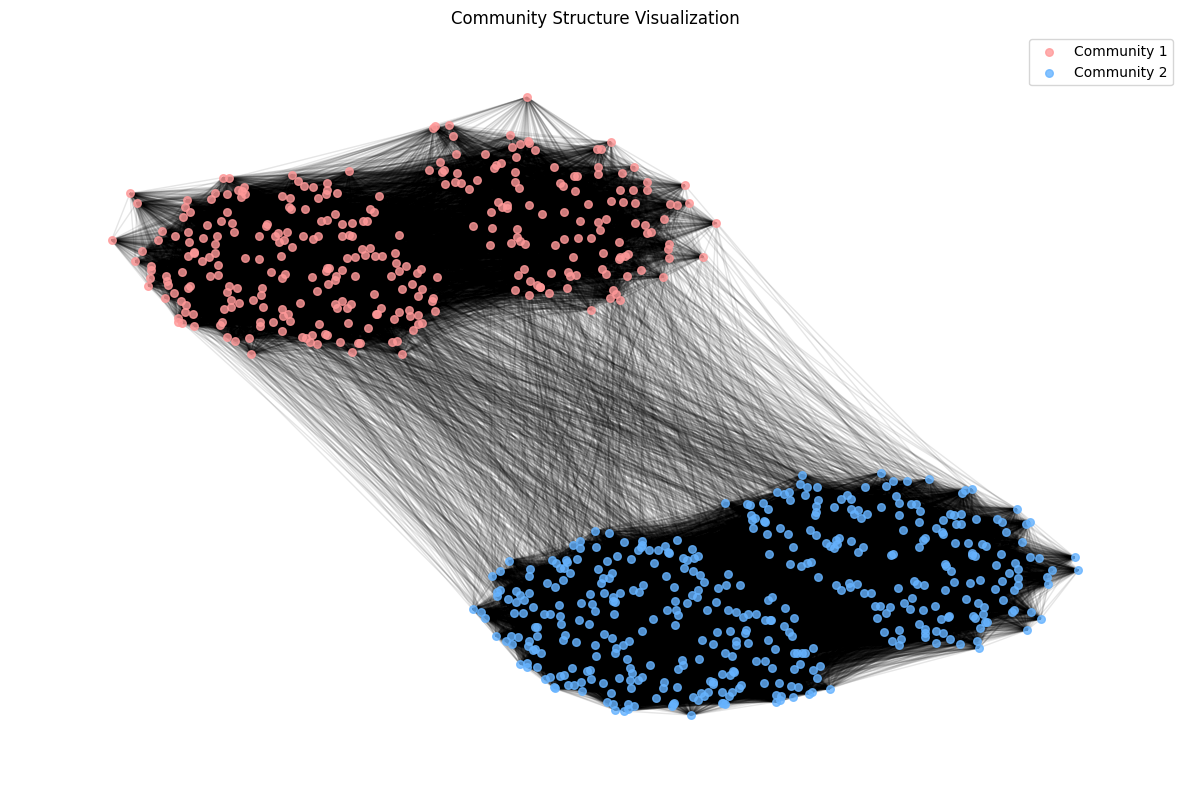

In [ ]:
import numpy as np
from scipy import sparse
import matplotlib.pyplot as plt

def modularity_detection(edge_file):
    edges = []
    with open(edge_file, 'r') as f:
        for line in f:
            i, j, weight = map(int, line.strip().split(','))
            edges.append((i, j, weight))
    
    # Find the maximum node ID to determine matrix size
    max_node_id = max(max(i, j) for i, j, _ in edges)
    n = max_node_id + 1  # +1 because node IDs start from 0
    
    print(f"Number of edges: {len(edges)}")
    print(f"Maximum node ID: {max_node_id}")
    
    # Create adjacency matrix using sparse matrix for efficiency
    A = sparse.lil_matrix((n, n))
    
    # Fill the adjacency matrix
    for i, j, weight in edges:
        A[i, j] = weight
        A[j, i] = weight  # Assuming undirected graph
    
    # Convert to CSR format for efficient arithmetic operations
    A = A.tocsr()
    
    # Calculate degrees of each node
    degrees = np.array(A.sum(axis=1)).flatten()
    
    # Calculate total number of edges (sum of all weights / 2 for undirected graph)
    m = sum(weight for _, _, weight in edges) / 2
    print(f"Total number of edges (m): {m}")
    
    # Function to calculate B*v without explicitly forming B
    def B_times_v(v):
        # B*v = A*v - (k*k^T/2m)*v = A*v - k*(k^T*v)/2m
        Av = A.dot(v)
        k_dot_v = np.dot(degrees, v)
        return Av - (degrees * k_dot_v) / (2 * m)
    
    # Power iteration to find the leading eigenvector
    def power_iteration(max_iter=100, tol=1e-6):
        # Initialize a random vector
        v = np.random.rand(n)
        v = v / np.linalg.norm(v)
        
        eigenvalue = 0
        prev_eigenvalue = -np.inf
        
        for _ in range(max_iter):
            # Compute B*v without forming B explicitly
            Bv = B_times_v(v)
            
            # Normalize
            v = Bv / np.linalg.norm(Bv)
            
            # Estimate eigenvalue using Rayleigh quotient
            eigenvalue = np.dot(v, B_times_v(v))
            
            # Check for convergence
            if abs(eigenvalue - prev_eigenvalue) < tol:
                break
                
            prev_eigenvalue = eigenvalue
        
        return eigenvalue, v
    
    # Compute the leading eigenvector
    eigenvalue, eigenvector = power_iteration()
    print(f"Leading eigenvalue: {eigenvalue:.4f}")
    
    # Create the split vector S based on the signs of the eigenvector
    s = np.sign(eigenvector)
    s[s == 0] = 1  # Handle potential zero values
    
    # Partition the nodes based on the sign
    community1 = [i for i in range(n) if s[i] > 0]
    community2 = [i for i in range(n) if s[i] < 0]
    
    print(f"Community 1 size: {len(community1)}")
    print(f"Community 2 size: {len(community2)}")
    
    # Calculate modularity value for this partition
    Q = 0
    for i in range(n):
        for j in range(n):
            Q += (A[i, j] - degrees[i] * degrees[j] / (2 * m)) * (s[i] * s[j]) / (4 * m)
    
    print(f"Modularity (Q): {Q:.4f}")
    
    # Print first few nodes of each community
    print("Sample nodes from Community 1:", community1[:10])
    print("Sample nodes from Community 2:", community2[:10])
    
    return community1, community2, s, Q

# Full implementation with explicit B calculation for verification
def explicit_modularity_detection(edge_file):
    # Read edges from file
    edges = []
    with open(edge_file, 'r') as f:
        for line in f:
            i, j, weight = map(int, line.strip().split(','))
            edges.append((i, j, weight))
    
    # Find the maximum node ID to determine matrix size
    max_node_id = max(max(i, j) for i, j, _ in edges)
    n = max_node_id + 1
    
    # Create adjacency matrix
    A = np.zeros((n, n))
    
    # Fill the adjacency matrix
    for i, j, weight in edges:
        A[i, j] = weight
        A[j, i] = weight  # Assuming undirected graph
    
    # Calculate degrees of each node
    degrees = np.sum(A, axis=1)
    
    # Calculate total number of edges
    m = sum(weight for _, _, weight in edges) / 2
    
    # Calculate the modularity matrix B
    B = np.zeros((n, n))
    for i in range(n):
        for j in range(n):
            B[i, j] = A[i, j] - (degrees[i] * degrees[j]) / (2 * m)
    
    # Find the leading eigenvector using numpy's built-in function
    eigenvalues, eigenvectors = np.linalg.eigh(B)
    
    # Get the largest eigenvalue and corresponding eigenvector
    # Note: eigenvalues are in ascending order, so we take the last one
    max_eigen_idx = np.argmax(eigenvalues)
    leading_eigenvalue = eigenvalues[max_eigen_idx]
    leading_eigenvector = eigenvectors[:, max_eigen_idx]
    
    # Create the split vector S based on the signs of the eigenvector
    s = np.sign(leading_eigenvector)
    s[s == 0] = 1  # Handle potential zero values
    
    # Partition the nodes
    community1 = [i for i in range(n) if s[i] > 0]
    community2 = [i for i in range(n) if s[i] < 0]
    
    # Calculate modularity value for this partition
    Q = 0
    for i in range(n):
        for j in range(n):
            Q += B[i, j] * (s[i] * s[j]) / (4 * m)
    
    return community1, community2, s, Q, B

# Function to visualize the graph with community structure
def visualize_communities(edge_file, s):
    # Read edges from file
    edges = []
    with open(edge_file, 'r') as f:
        for line in f:
            i, j, weight = map(int, line.strip().split(','))
            edges.append((i, j))
    
    # Create a networkx graph
    try:
        import networkx as nx
        
        G = nx.Graph()
        for i, j in edges:
            G.add_edge(i, j)
        
        # Assign communities
        for i, sign in enumerate(s):
            if i in G:  # Only add nodes that are in the graph
                G.nodes[i]['community'] = 1 if sign > 0 else 2
        
        # Position nodes using force-directed layout
        pos = nx.spring_layout(G, seed=42)
        
        # Draw the graph
        plt.figure(figsize=(12, 8))
        
        # Colors for different communities
        colors = ['#ff9999', '#66b3ff']
        
        for comm_idx, color in enumerate([1, 2]):
            nodes = [n for n, d in G.nodes(data=True) if d.get('community') == color]
            nx.draw_networkx_nodes(G, pos, nodelist=nodes, node_color=colors[comm_idx], 
                                  node_size=30, alpha=0.8, label=f'Community {color}')
        
        nx.draw_networkx_edges(G, pos, alpha=0.1)
        
        plt.title("Community Structure Visualization")
        plt.legend()
        plt.axis('off')
        plt.tight_layout()
        
        # Save the figure
        plt.savefig('community_structure.png')
        print("Visualization saved as 'community_structure.png'")
        
    except ImportError:
        print("NetworkX not available. Skipping visualization.")

edge_file = "sparse_adj.txt"

community1, community2, s, Q = modularity_detection(edge_file)

visualize_communities(edge_file, s)
